In [1]:
import os
import pickle
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
from matplotlib.cm import ScalarMappable
import seaborn as sns
import tensorflow as tf
from scipy.stats import pearsonr, gaussian_kde
from sklearn.decomposition import PCA
from sgcc import *

In [2]:
X = tf.convert_to_tensor([0.02,0.04,0.08,0.1,0.12,0.16,0.2,0.24,0.28,0.32], dtype = tf.float32)

In [3]:
v1_xs_file = os.path.join("project_datafiles", "v1_ori_phase_condition_pcascores_wcomp.pkl")
v1_scores = pd.read_pickle(v1_xs_file)
v1_scores_condition_averaged = np.array([np.array(x) for x in v1_scores.scores.values]).mean(0)
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [4]:
Y_true = v1_scores_condition_averaged[:2,:,:].transpose(0,2,1)

In [5]:
param_bounds = {
    "fts": [20, 200],
    "t": [40, 100],
    "ampc": [0.02, 0.32],
    "ampg": [0.1, 4],
    "ampw": [0.01,0.32],
    "d": [10, 40],
    "inh_d": [0, 40],
    "inh_w": [0, 3],
}

## 1) Initial optimization

In [6]:
sgcc = SGCCircuit(param_bounds)

In [7]:
sgcc.initialize_random_parameters(n_v1=2, n_lgn=3, n_sample=1000)

In [8]:
optimizer = Optimize(sgcc, epochs=10000, loss_threshold=0.11)

Optimizer initialized with <keras.optimizers.optimizer_v2.adam.Adam object at 0x00000166599BD0D0>


In [9]:
loss_decay = optimizer.fit(X, Y_true)

Training step = 0, N_exploration_samples = 1000,
min_loss = 0.5139423608779907
med_loss = 6.000706195831299
max_loss = 42.61598587036133

Training step = 100, N_exploration_samples = 1000,
min_loss = 0.4359808564186096
med_loss = 4.404399871826172
max_loss = 37.565818786621094

Training step = 200, N_exploration_samples = 1000,
min_loss = 0.3787435293197632
med_loss = 3.3230626583099365
max_loss = 33.47035598754883

Training step = 300, N_exploration_samples = 1000,
min_loss = 0.3214101195335388
med_loss = 2.595825672149658
max_loss = 29.78749656677246

Training step = 400, N_exploration_samples = 1000,
min_loss = 0.28482329845428467
med_loss = 2.038996934890747
max_loss = 26.27729034423828

Training step = 500, N_exploration_samples = 1000,
min_loss = 0.2600535452365875
med_loss = 1.6379308700561523
max_loss = 22.958513259887695

Training step = 600, N_exploration_samples = 1000,
min_loss = 0.22469384968280792
med_loss = 1.3284931182861328
max_loss = 19.858917236328125

Training step 

In [10]:
res = optimizer.outputs
param_history = res['param_history']

In [11]:
loss_decay = res['loss_decay']
last_epoch = loss_decay[-1]
best = np.where(last_epoch == last_epoch.min())[0][0]
print(f"Index of best parameters: {best}, loss = {last_epoch[best]}")

Index of best parameters: 208, loss = 0.109619140625


In [12]:
def minmax_norm(array, lower, upper):
    if (array.max() - array.min()) != 0:
        norm = (array - array.min()) / (array.max() - array.min())
        return lower + (norm * (upper-lower))
    else:
        return array

Text(0.5, 1.0, 'Loss decay over training epochs')

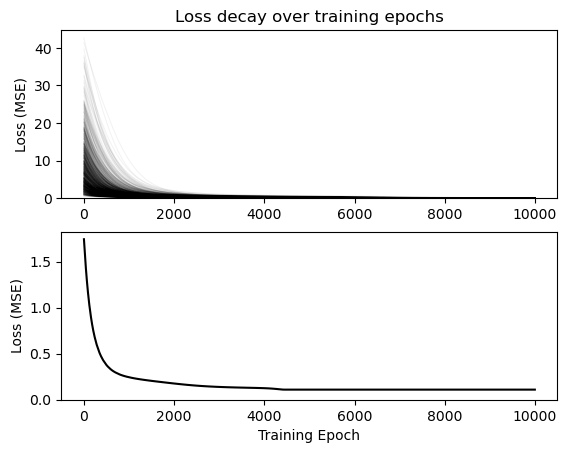

In [13]:
fig, ax = plt.subplots(2)

for i, decay in enumerate(loss_decay.T):
    ax[0].plot(decay, alpha = 0.05, color = 'black', linewidth = 0.75)
#ax[0].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_ylim(0,)

ax[1].set_ylabel("Loss (MSE)")
ax[1].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_ylim(0.)
ax[0].set_title("Loss decay over training epochs")

Text(0.525, 0.95, 'Distribution of V1 parameters post-optimization')

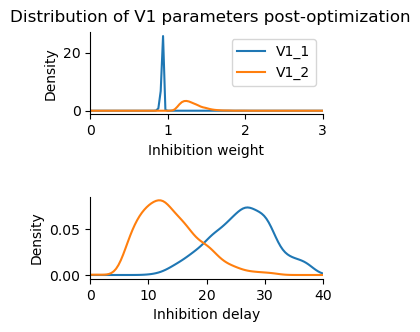

In [14]:
fig, ax = plt.subplots(2,1, figsize = (3,2*(8/5)))

for i in range(2):
    i_ = np.abs(i-1)
    for u in range(2):
        x = np.linspace(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1],
            100
        )
        data = param_history['V1_params'][:,-1,u,0,i_,0,0]
        kde = gaussian_kde(data)
        y = kde(x)

        ax[i].plot(x,y, label = f'V1_{u+1}')
        ax[i].set_xlim(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1]
        )
        ax[i].set_ylabel("Density")
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

ax[0].set_xlabel('Inhibition weight')
ax[1].set_xlabel('Inhibition delay')
ax[0].legend()
fig.subplots_adjust(hspace=1)
plt.suptitle("Distribution of V1 parameters post-optimization", x = 0.525, y = 0.95)

Text(0.525, 0.95, 'Distribution of dLGN parameters post-optimization')

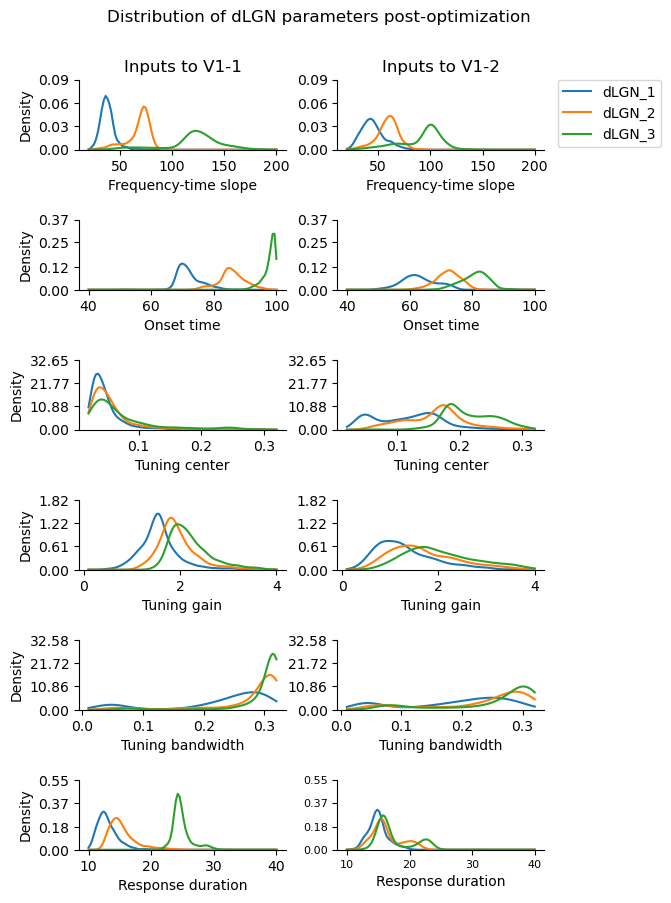

In [15]:
fig, ax = plt.subplots(6,2, figsize = (6,10))

param_labels = [
    'Frequency-time slope',
    'Onset time',
    'Tuning center',
    'Tuning gain',
    'Tuning bandwidth',
    'Response duration'
]

neuron_labels = [f'dLGN_{i+1}' for i in range(3)]


for row in range(6):
    ymax = []
    for i in range(3):
        for u in range(2):
            data = param_history['dLGN_params'][:,-1,u,i,row,0,0]
            x = np.linspace(
                list(param_bounds.values())[:6][row][0],
                list(param_bounds.values())[:6][row][1], 
                100
            )
            kde = gaussian_kde(data)
            y = kde(x)

            ymax.append(y.max())
            
            ax[row, u].plot(x, y, label = neuron_labels[i])
            ax[row, u].set_xlabel(param_labels[row])

    ax[row, 0].set_ylabel("Density")
    for u in range(2):
        ax[row, u].set_ylim(0, np.max(ymax)+np.max(ymax)*0.25)
        ax[row, u].set_yticks(np.linspace(0, np.max(ymax)+np.max(ymax)*0.25, 4).round(2))
        ax[row, u].spines['top'].set_visible(False)
        ax[row, u].spines['right'].set_visible(False)

fig.subplots_adjust(hspace = 1, wspace=0.25)
plt.tick_params(labelsize = 8)
ax[0,1].legend(fontsize = 10, bbox_to_anchor = (1.6,1.1))
ax[0,0].set_title("Inputs to V1-1")
ax[0,1].set_title("Inputs to V1-2")
plt.suptitle("Distribution of dLGN parameters post-optimization", x = 0.525, y = 0.95)

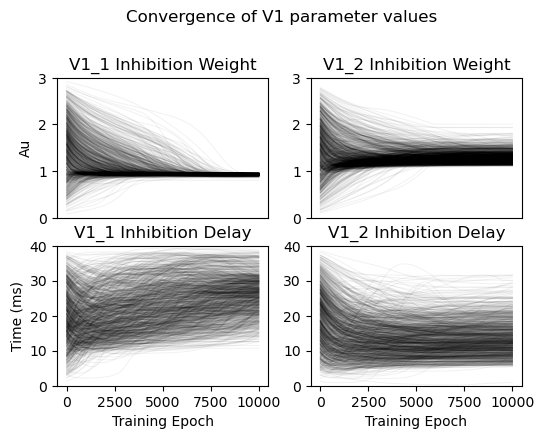

In [16]:
## inhibition weight::inhibition delay

fig, ax = plt.subplots(2,2, figsize = (6,4))

inh_w = 1
v1_n = 0 
ax[0,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# 
v1_n = 1
ax[0,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a0
inh_d = 0
v1_n = 0
ax[1,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a1
v1_n = 1
ax[1,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

ax[0,0].set_ylim(0,3)
ax[0,0].set_title("V1_1 Inhibition Weight")
ax[0,0].set_xticks([])
ax[0,0].set_ylabel("Au")

ax[0,1].set_ylim(0,3)
ax[0,1].set_title("V1_2 Inhibition Weight")
ax[0,1].set_xticks([])

ax[1,0].set_ylim(0,40)
ax[1,0].set_title("V1_1 Inhibition Delay")
ax[1,0].set_ylabel("Time (ms)")
ax[1,0].set_xlabel("Training Epoch")
# ax[1,0].set_xticks(np.arange(0,20500,500))
# ax[1,0].set_xticklabels(np.arange(0,20500,500), rotation = 90)

ax[1,1].set_ylim(0,40)
ax[1,1].set_title("V1_2 Inhibition Delay")
ax[1,1].set_xlabel("Training Epoch")
# ax[1,1].set_xticks(np.arange(0,20500,500))
# ax[1,1].set_xticklabels(np.arange(0,20500,500), rotation = 90)
plt.suptitle("Convergence of V1 parameter values", y = 1.05)
plt.show()

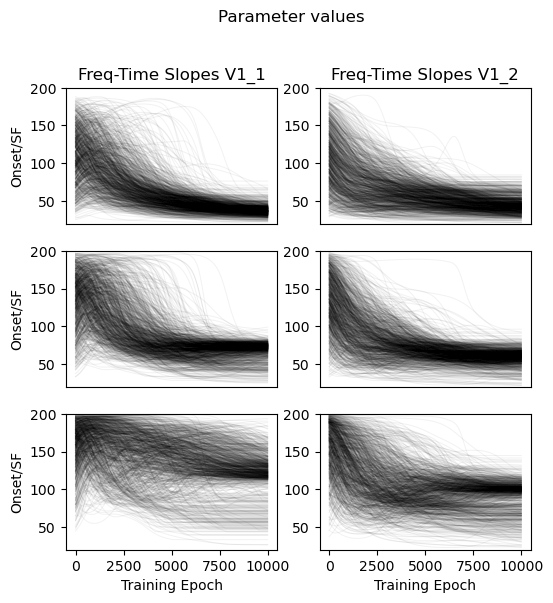

In [17]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 0

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Freq-Time Slopes V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,200)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

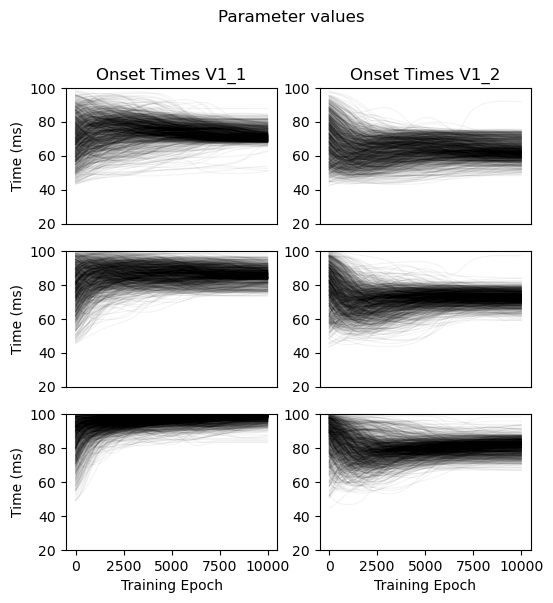

In [18]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 1

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Onset Times V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,100)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
plt.suptitle("Parameter values", y = 1.01)
plt.show()

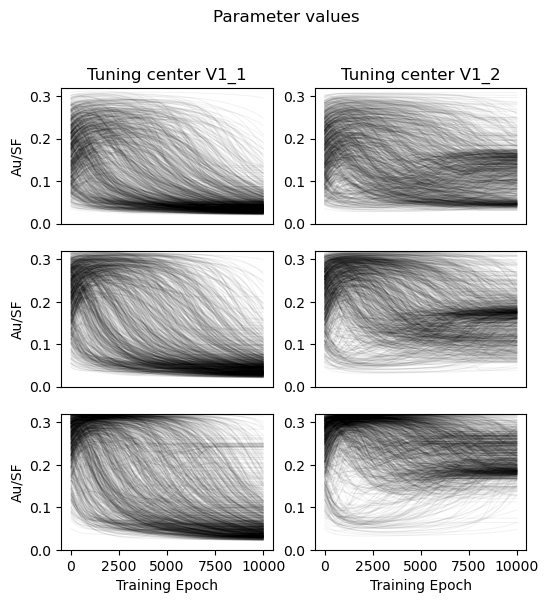

In [19]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 2

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning center V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Au/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,0.32)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

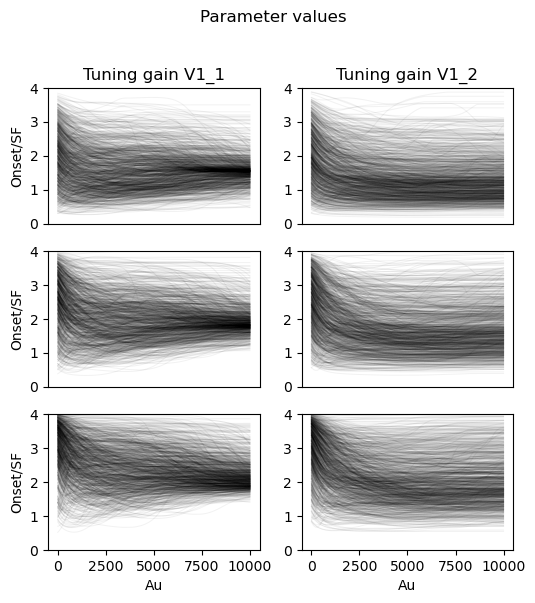

In [20]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 3

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning gain V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,4)
for i in range(2):
    ax[2,i].set_xlabel("Au")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

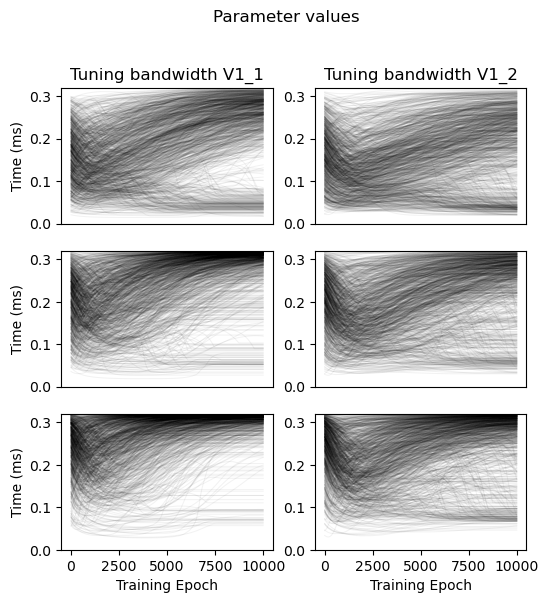

In [21]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 4

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning bandwidth V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,0.32)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

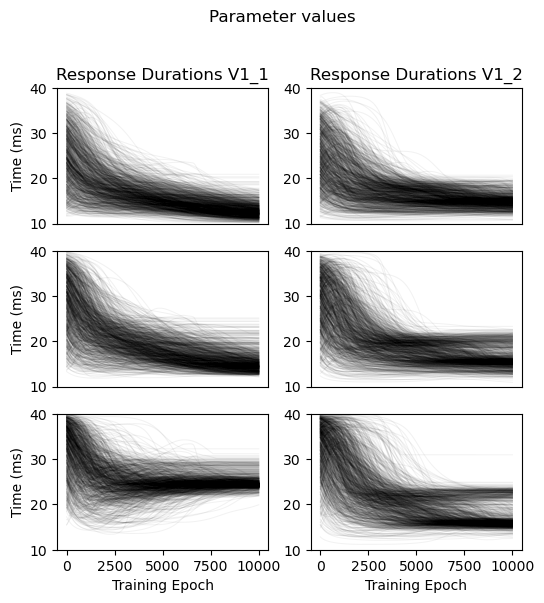

In [22]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 5

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Response Durations V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(10,40)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

In [23]:
res = param_history['dLGN_params'].squeeze()
print(res.shape[2:])
n_samples, n_epochs = res.shape[:2]
n_params = np.prod(res.shape[2:])# + np.prod(r2.shape[2:])

res = res.reshape(res.shape[0] * res.shape[1], np.prod(res.shape[2:]))

(2, 3, 6)


In [24]:
pca = PCA() # all epochs included
res_transformed_pca = pca.fit_transform(res).reshape(n_samples, n_epochs, n_params)

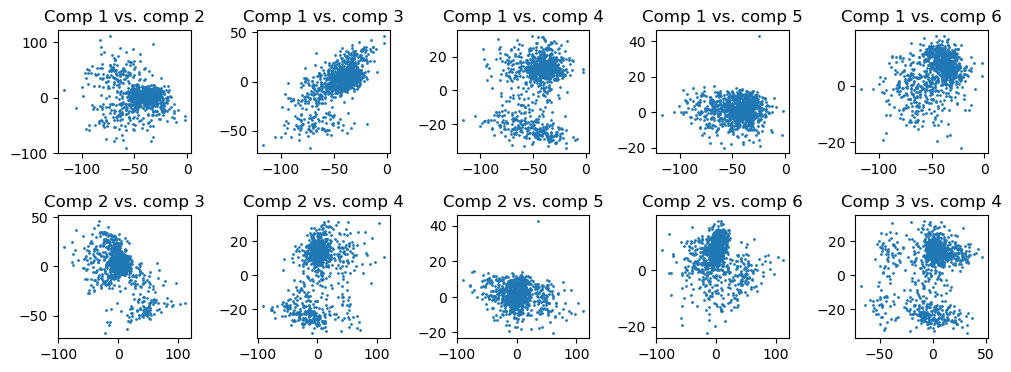

In [25]:
fig, ax = plt.subplots(2,5, figsize = (12,4))

comp_pairs = (list(combinations(np.arange(6), 2)))
i = 0
for row in range(2):
    for col in range(5):
        c0, c1 = comp_pairs[i]
        ax[row, col].scatter(res_transformed_pca[:,-1,c0], res_transformed_pca[:,-1,c1], s = 1) # last epoch
        ax[row, col].set_title(f"Comp {c0+1} vs. comp {c1+1}")
        i+=1

fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [26]:
lgn_params = [
    'Frequency-time slope',
    'Onset time',
    'Tuning center',
    'Tuning gain',
    'Tuning bandwidth',
    'Response duration'
]

v1_params = [
    'Inhibition delay',
    'Inhibition weight'
]

lgn_units = [
    'dLGN_1 into V1_1',
    'dLGN_2 into V1_1',
    'dLGN_3 into V1_1',
    'dLGN_1 into V1_2',
    'dLGN_2 into V1_2',
    'dLGN_3 into V1_2',
]

v1_units = [
    'V1_1',
    'V1_2'
]

full_lgn_params = []
for unit in lgn_units:
    for param in lgn_params:
        full_lgn_params.append(f"{param} ({unit})")

full_v1_params = []
for unit in v1_units:
    for param in v1_params:
        full_v1_params.append(f"{param} ({unit})")
        
param_names = full_lgn_params+full_v1_params

In [27]:
len(param_names)

40

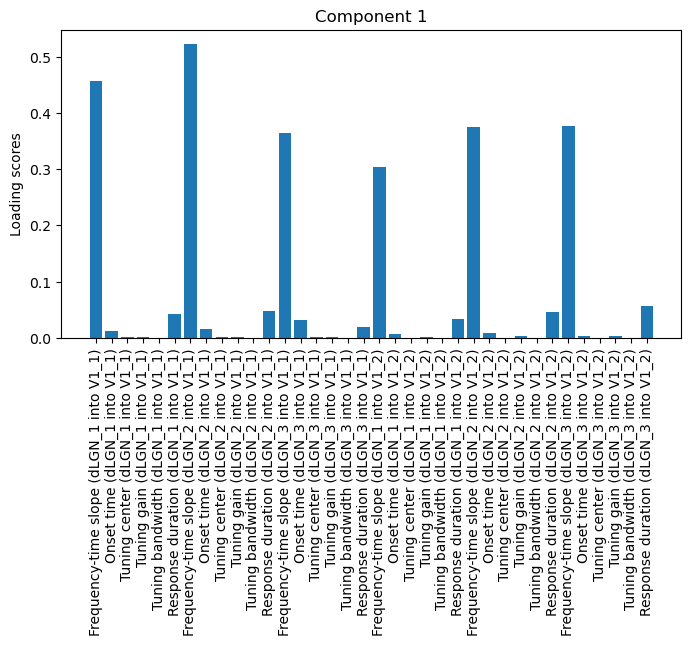

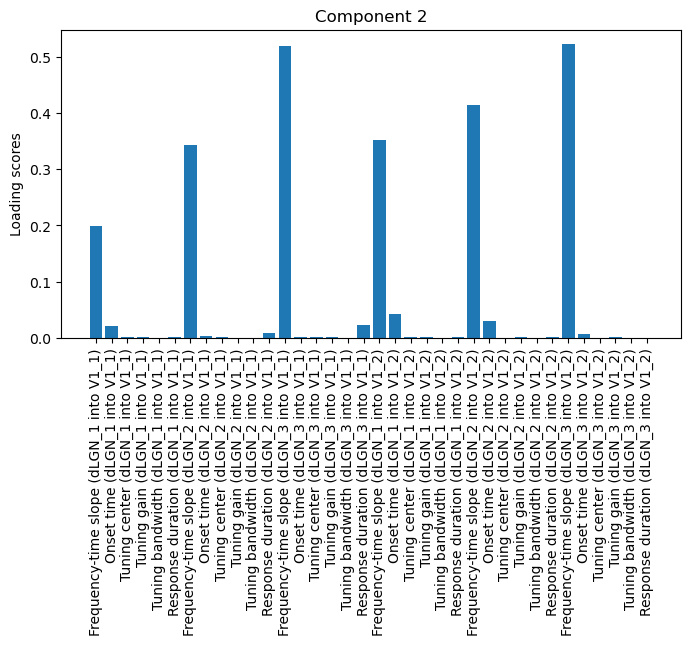

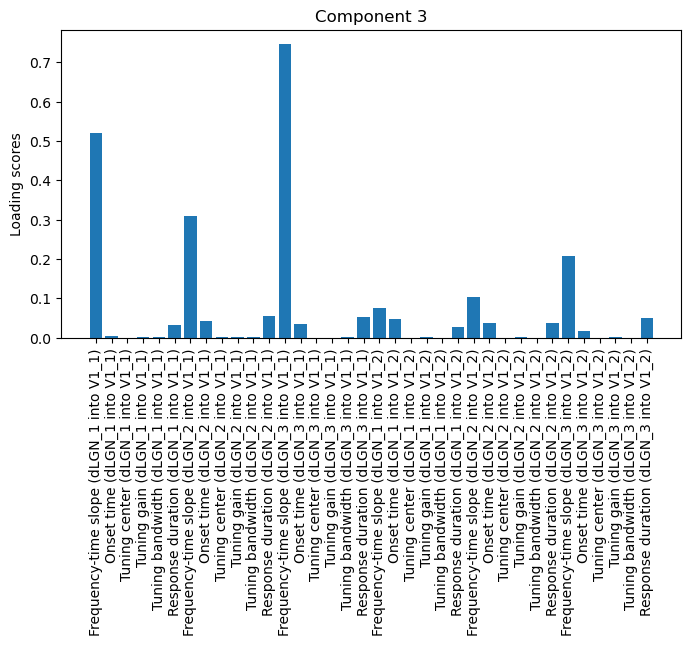

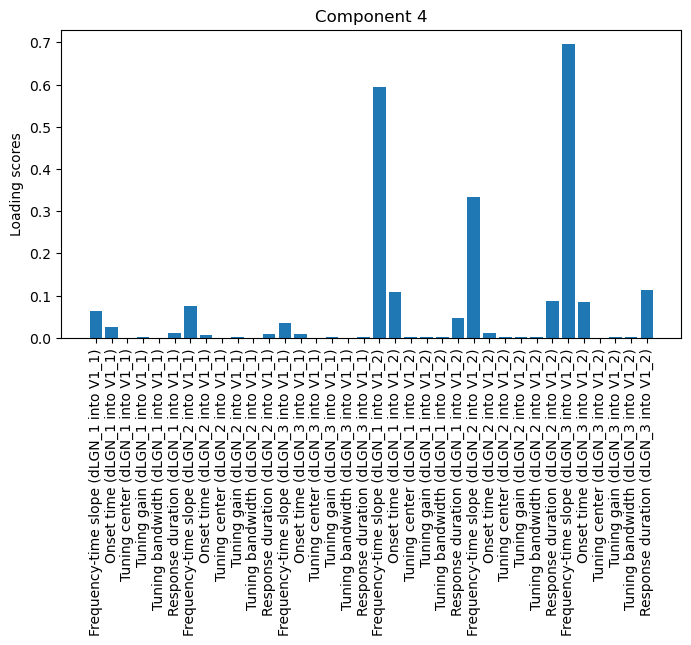

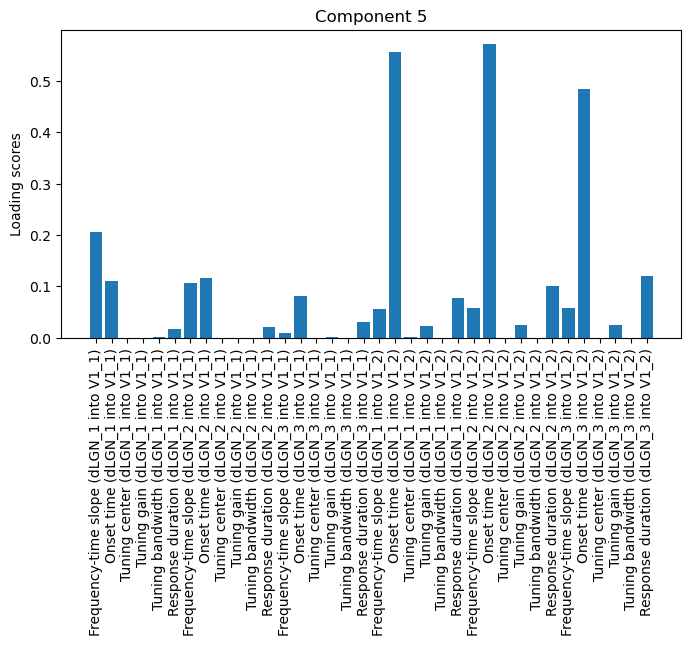

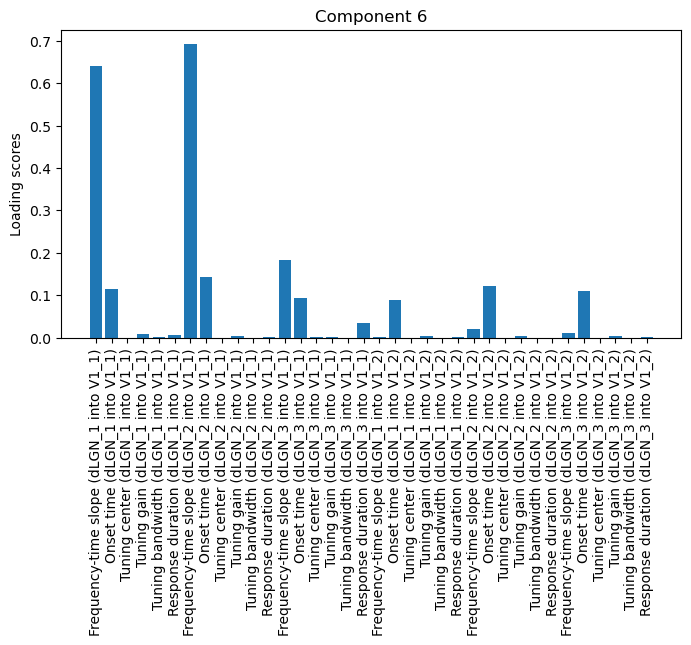

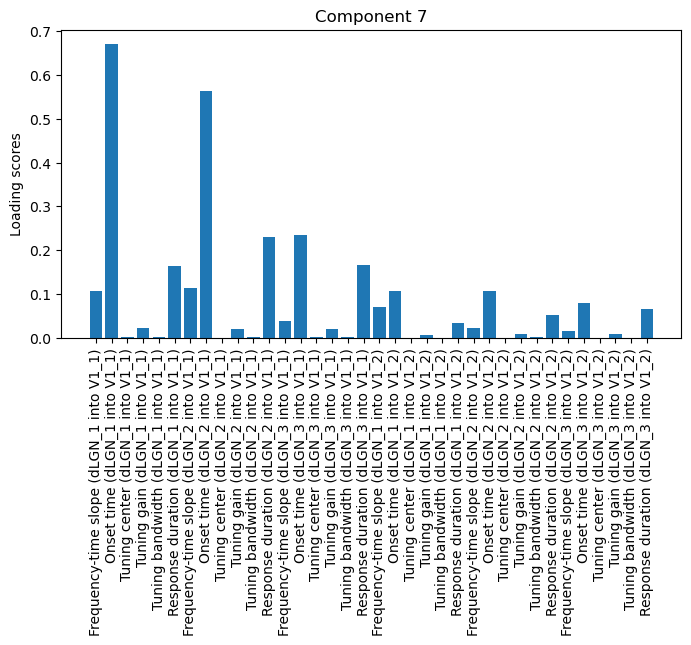

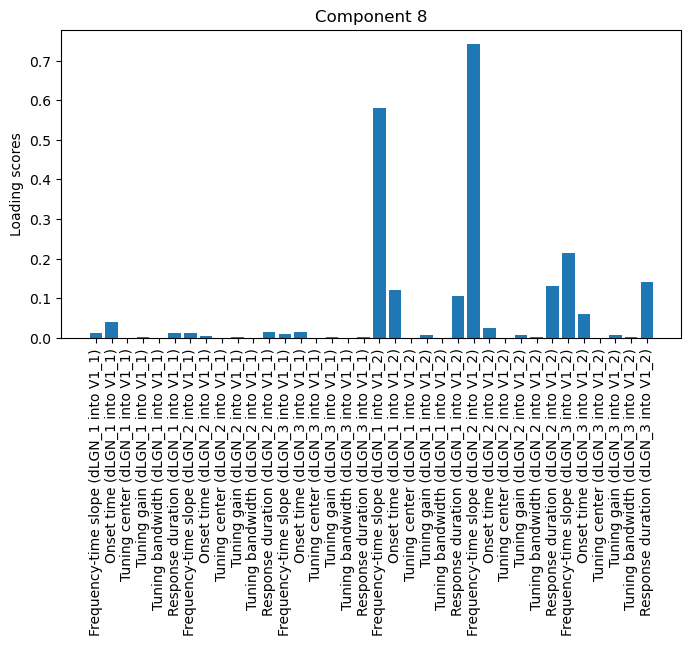

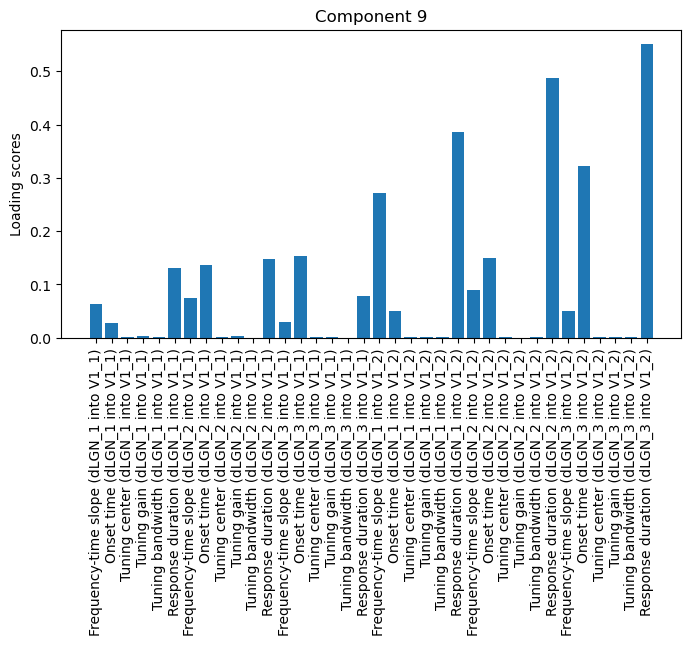

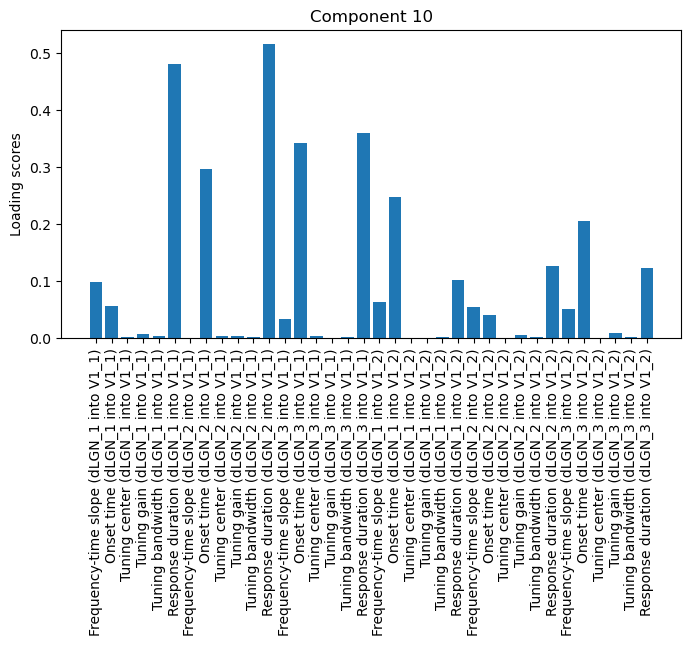

In [28]:
for i in range(10):
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.bar(np.arange(36), np.abs(pca.components_[i]))
    ax.set_xticks(np.arange(36))
    ax.set_xticklabels(param_names[:36], rotation = 90)
    ax.set_ylabel("Loading scores")
    ax.set_title(f"Component {i+1}")

## 2) Local perturbation restart (testing the stability of the solutions)

In [29]:
sgcc = SGCCircuit(param_bounds)

In [30]:
sgcc.load_saved_parameters(
    {x[0]:x[1] + tf.random.uniform(x[1].shape, -0.5, 0.5)
    for x in optimizer.outputs['final_epoch_params'].items()}
)

In [31]:
optimizer = Optimize(sgcc, epochs=10000, loss_threshold=0.11)

Optimizer initialized with <keras.optimizers.optimizer_v2.adam.Adam object at 0x0000016B99EBB160>


In [32]:
loss_decay = optimizer.fit(X, Y_true)

Training step = 0, N_exploration_samples = 1000,
min_loss = 0.13522540032863617
med_loss = 0.24610966444015503
max_loss = 0.8155620694160461

Training step = 100, N_exploration_samples = 1000,
min_loss = 0.11282449960708618
med_loss = 0.16204652190208435
max_loss = 0.47444331645965576

Training step = 200, N_exploration_samples = 1000,
min_loss = 0.10851489007472992
med_loss = 0.1322285234928131
max_loss = 0.2962231934070587

Training step = 300, N_exploration_samples = 1000,
min_loss = 0.10840463638305664
med_loss = 0.12061518430709839
max_loss = 0.21087780594825745

Training step = 400, N_exploration_samples = 1000,
min_loss = 0.10840463638305664
med_loss = 0.11583773791790009
max_loss = 0.16870208084583282

Training step = 500, N_exploration_samples = 1000,
min_loss = 0.10840463638305664
med_loss = 0.11325076222419739
max_loss = 0.14628981053829193

Training step = 600, N_exploration_samples = 1000,
min_loss = 0.10840463638305664
med_loss = 0.11184471845626831
max_loss = 0.145494341

In [33]:
optimizer.save_state('sgcc_mop_2_9_26', write=True)

In [34]:
res = optimizer.outputs
param_history = res['param_history']

In [35]:
loss_decay = res['loss_decay']
last_epoch = loss_decay[-1]
best = np.where(last_epoch == last_epoch.min())[0][0]
print(f"Index of best parameters: {best}, loss = {last_epoch[best]}")

Index of best parameters: 543, loss = 0.1083984375


In [36]:
def minmax_norm(array, lower, upper):
    if (array.max() - array.min()) != 0:
        norm = (array - array.min()) / (array.max() - array.min())
        return lower + (norm * (upper-lower))
    else:
        return array

Text(0.5, 1.0, 'Loss decay over training epochs')

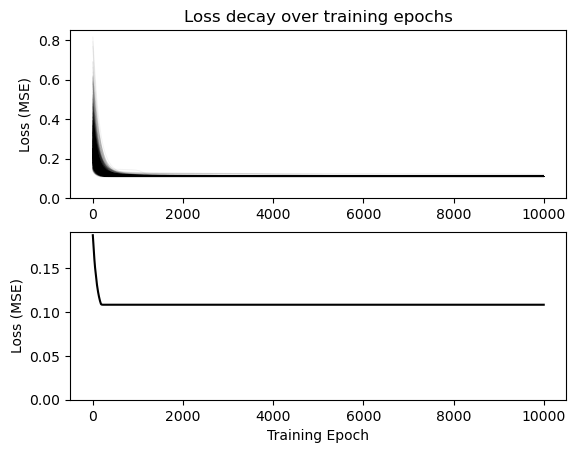

In [37]:
fig, ax = plt.subplots(2)

for i, decay in enumerate(loss_decay.T):
    ax[0].plot(decay, alpha = 0.05, color = 'black', linewidth = 0.75)
#ax[0].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_xlabel("Training Epoch")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_ylim(0,)

ax[1].set_ylabel("Loss (MSE)")
ax[1].plot(loss_decay[:,best], alpha = 1, color = 'black')
ax[1].set_ylim(0.)
ax[0].set_title("Loss decay over training epochs")

Text(0.525, 0.95, 'Distribution of V1 parameters post-optimization')

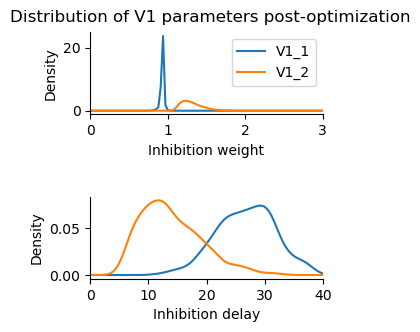

In [38]:
fig, ax = plt.subplots(2,1, figsize = (3,2*(8/5)))

for i in range(2):
    i_ = np.abs(i-1)
    for u in range(2):
        x = np.linspace(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1],
            100
        )
        data = param_history['V1_params'][:,-1,u,0,i_,0,0]
        kde = gaussian_kde(data)
        y = kde(x)

        ax[i].plot(x,y, label = f'V1_{u+1}')
        ax[i].set_xlim(
            list(param_bounds.values())[-1-i][0],
            list(param_bounds.values())[-1-i][1]
        )
        ax[i].set_ylabel("Density")
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

ax[0].set_xlabel('Inhibition weight')
ax[1].set_xlabel('Inhibition delay')
ax[0].legend()
fig.subplots_adjust(hspace=1)
plt.suptitle("Distribution of V1 parameters post-optimization", x = 0.525, y = 0.95)

Text(0.525, 0.95, 'Distribution of dLGN parameters post-optimization')

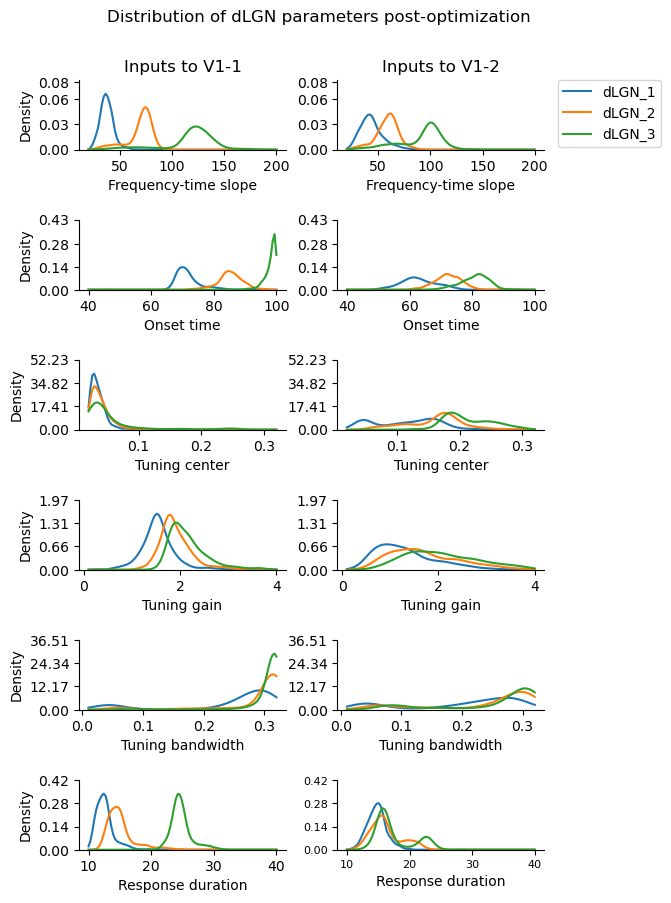

In [39]:
fig, ax = plt.subplots(6,2, figsize = (6,10))

param_labels = [
    'Frequency-time slope',
    'Onset time',
    'Tuning center',
    'Tuning gain',
    'Tuning bandwidth',
    'Response duration'
]

neuron_labels = [f'dLGN_{i+1}' for i in range(3)]


for row in range(6):
    ymax = []
    for i in range(3):
        for u in range(2):
            data = param_history['dLGN_params'][:,-1,u,i,row,0,0]
            x = np.linspace(
                list(param_bounds.values())[:6][row][0],
                list(param_bounds.values())[:6][row][1], 
                100
            )
            kde = gaussian_kde(data)
            y = kde(x)

            ymax.append(y.max())
            
            ax[row, u].plot(x, y, label = neuron_labels[i])
            ax[row, u].set_xlabel(param_labels[row])

    ax[row, 0].set_ylabel("Density")
    for u in range(2):
        ax[row, u].set_ylim(0, np.max(ymax)+np.max(ymax)*0.25)
        ax[row, u].set_yticks(np.linspace(0, np.max(ymax)+np.max(ymax)*0.25, 4).round(2))
        ax[row, u].spines['top'].set_visible(False)
        ax[row, u].spines['right'].set_visible(False)

fig.subplots_adjust(hspace = 1, wspace=0.25)
plt.tick_params(labelsize = 8)
ax[0,1].legend(fontsize = 10, bbox_to_anchor = (1.6,1.1))
ax[0,0].set_title("Inputs to V1-1")
ax[0,1].set_title("Inputs to V1-2")
plt.suptitle("Distribution of dLGN parameters post-optimization", x = 0.525, y = 0.95)

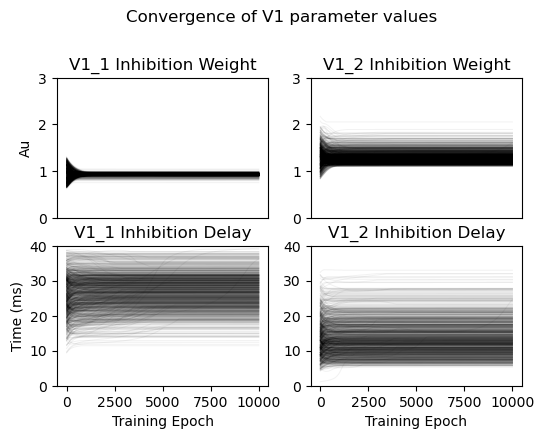

In [40]:
## inhibition weight::inhibition delay

fig, ax = plt.subplots(2,2, figsize = (6,4))

inh_w = 1
v1_n = 0 
ax[0,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# 
v1_n = 1
ax[0,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_w,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a0
inh_d = 0
v1_n = 0
ax[1,0].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

# a1
v1_n = 1
ax[1,1].plot(
    param_history['V1_params'][:,:,v1_n,0,inh_d,0,0].T,
    linewidth=0.75,
    alpha=0.05,
    color = 'black'
)

ax[0,0].set_ylim(0,3)
ax[0,0].set_title("V1_1 Inhibition Weight")
ax[0,0].set_xticks([])
ax[0,0].set_ylabel("Au")

ax[0,1].set_ylim(0,3)
ax[0,1].set_title("V1_2 Inhibition Weight")
ax[0,1].set_xticks([])

ax[1,0].set_ylim(0,40)
ax[1,0].set_title("V1_1 Inhibition Delay")
ax[1,0].set_ylabel("Time (ms)")
ax[1,0].set_xlabel("Training Epoch")
# ax[1,0].set_xticks(np.arange(0,20500,500))
# ax[1,0].set_xticklabels(np.arange(0,20500,500), rotation = 90)

ax[1,1].set_ylim(0,40)
ax[1,1].set_title("V1_2 Inhibition Delay")
ax[1,1].set_xlabel("Training Epoch")
# ax[1,1].set_xticks(np.arange(0,20500,500))
# ax[1,1].set_xticklabels(np.arange(0,20500,500), rotation = 90)
plt.suptitle("Convergence of V1 parameter values", y = 1.05)
plt.show()

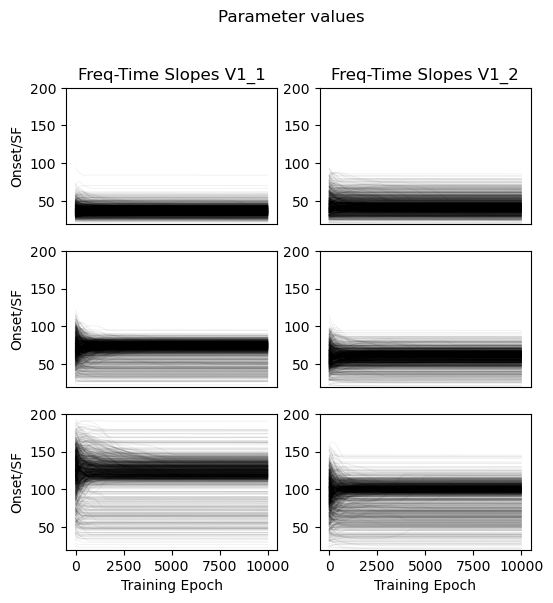

In [41]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 0

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Freq-Time Slopes V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,200)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

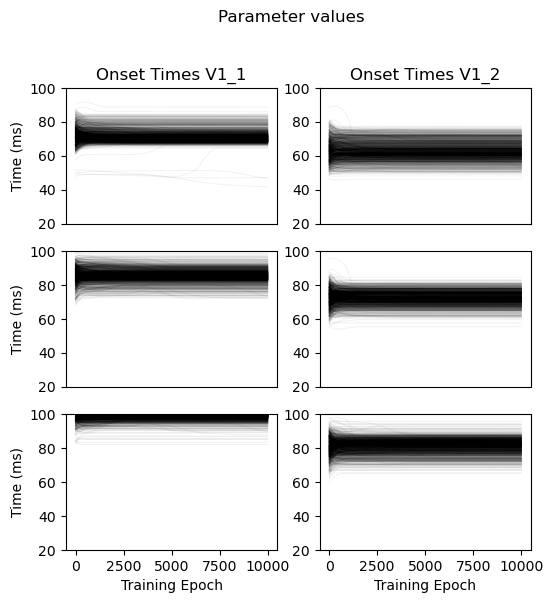

In [42]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 1

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Onset Times V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(20,100)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
plt.suptitle("Parameter values", y = 1.01)
plt.show()

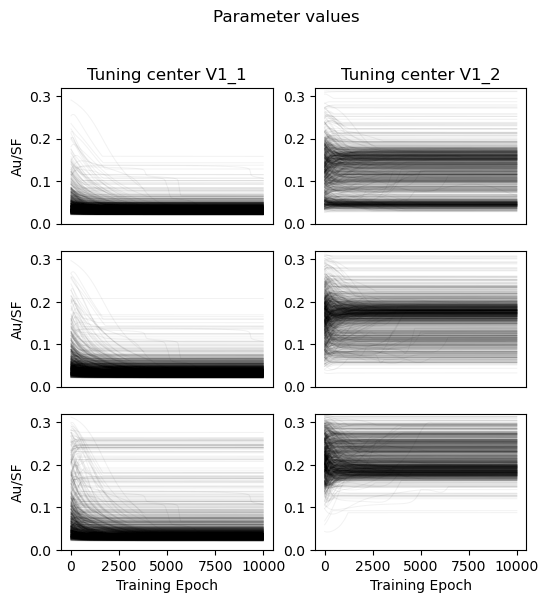

In [43]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 2

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning center V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Au/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,0.32)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

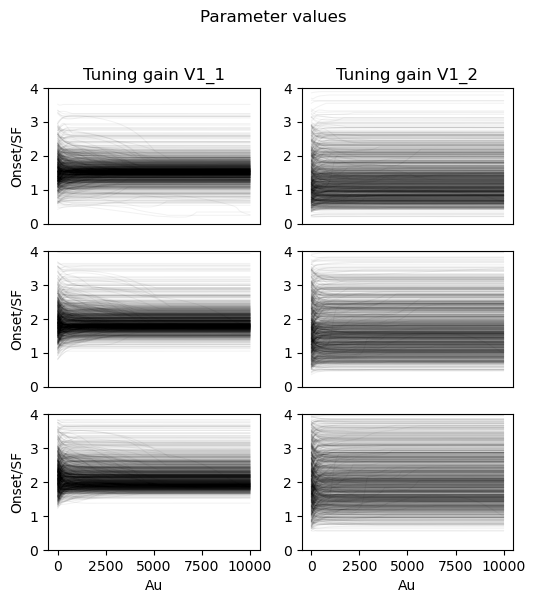

In [44]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 3

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning gain V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Onset/SF")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,4)
for i in range(2):
    ax[2,i].set_xlabel("Au")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

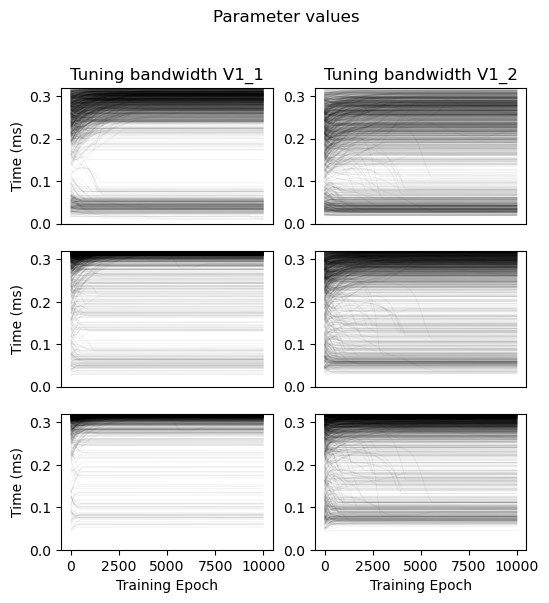

In [45]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 4

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Tuning bandwidth V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(0,0.32)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

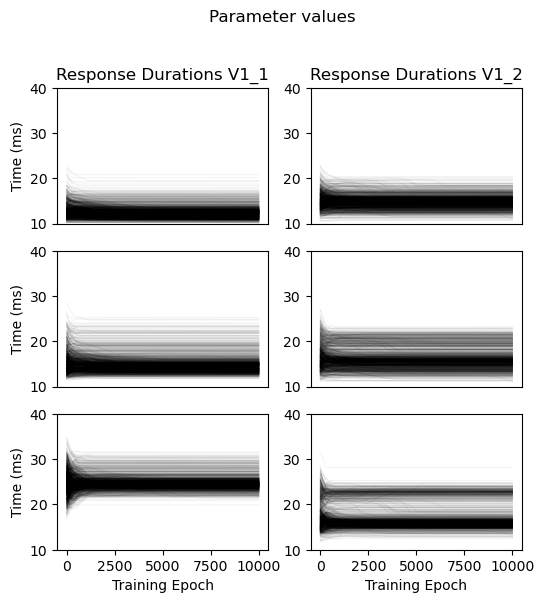

In [46]:
fig, ax = plt.subplots(3,2, figsize = (6,6))
norm = plt.Normalize(0, 1)

param = 5

for col in range(2):
    for row in range(3):
        data = param_history['dLGN_params'][:,:,col,row,param,0,0].T
        ax[row,col].plot(
        param_history['dLGN_params'][:,:,col,row,param,0,0].T,
            linewidth=0.75,
            alpha=0.05,
            color='black'
        )

for i in range(2):
    ax[0,i].set_title(f"Response Durations V1_{i+1}")
for i in range(3):
    ax[i,0].set_ylabel("Time (ms)")
for row in range(2):
    for col in range(2):
        ax[row,col].set_xticks([])
for row in range(3):
    for col in range(2):
        ax[row,col].set_ylim(10,40)
for i in range(2):
    ax[2,i].set_xlabel("Training Epoch")
    # ax[2,i].set_xticks(np.arange(0,5500,500))
    # ax[2,i].set_xticklabels(np.arange(0,5500,500), rotation = 90)
plt.suptitle("Parameter values", y = 1.01)
plt.show()

In [47]:
res = param_history['dLGN_params'].squeeze()
print(res.shape[2:])
n_samples, n_epochs = res.shape[:2]
n_params = np.prod(res.shape[2:])# + np.prod(r2.shape[2:])

res = res.reshape(res.shape[0] * res.shape[1], np.prod(res.shape[2:]))

(2, 3, 6)


In [48]:
pca = PCA() # all epochs included
res_transformed_pca = pca.fit_transform(res).reshape(n_samples, n_epochs, n_params)

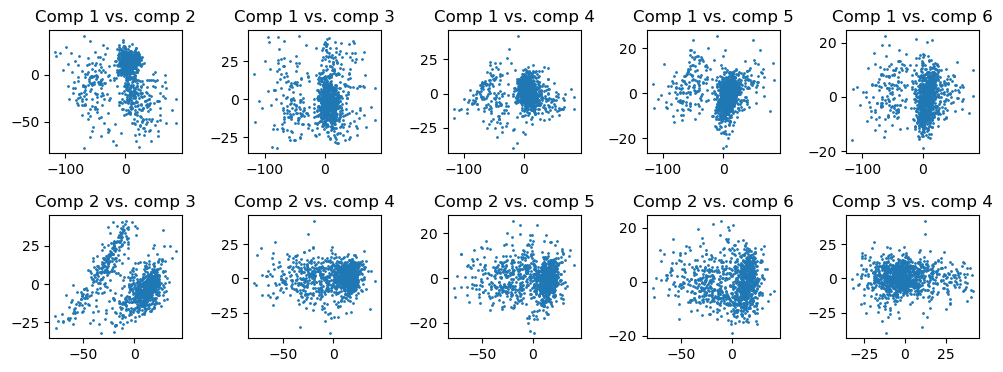

In [49]:
fig, ax = plt.subplots(2,5, figsize = (12,4))

comp_pairs = (list(combinations(np.arange(6), 2)))
i = 0
for row in range(2):
    for col in range(5):
        c0, c1 = comp_pairs[i]
        ax[row, col].scatter(res_transformed_pca[:,-1,c0], res_transformed_pca[:,-1,c1], s = 1) # last epoch
        ax[row, col].set_title(f"Comp {c0+1} vs. comp {c1+1}")
        i+=1

fig.subplots_adjust(hspace = 0.5, wspace = 0.5)

In [50]:
lgn_params = [
    'Frequency-time slope',
    'Onset time',
    'Tuning center',
    'Tuning gain',
    'Tuning bandwidth',
    'Response duration'
]

v1_params = [
    'Inhibition delay',
    'Inhibition weight'
]

lgn_units = [
    'dLGN_1 into V1_1',
    'dLGN_2 into V1_1',
    'dLGN_3 into V1_1',
    'dLGN_1 into V1_2',
    'dLGN_2 into V1_2',
    'dLGN_3 into V1_2',
]

v1_units = [
    'V1_1',
    'V1_2'
]

full_lgn_params = []
for unit in lgn_units:
    for param in lgn_params:
        full_lgn_params.append(f"{param} ({unit})")

full_v1_params = []
for unit in v1_units:
    for param in v1_params:
        full_v1_params.append(f"{param} ({unit})")
        
param_names = full_lgn_params+full_v1_params

In [51]:
len(param_names)

40

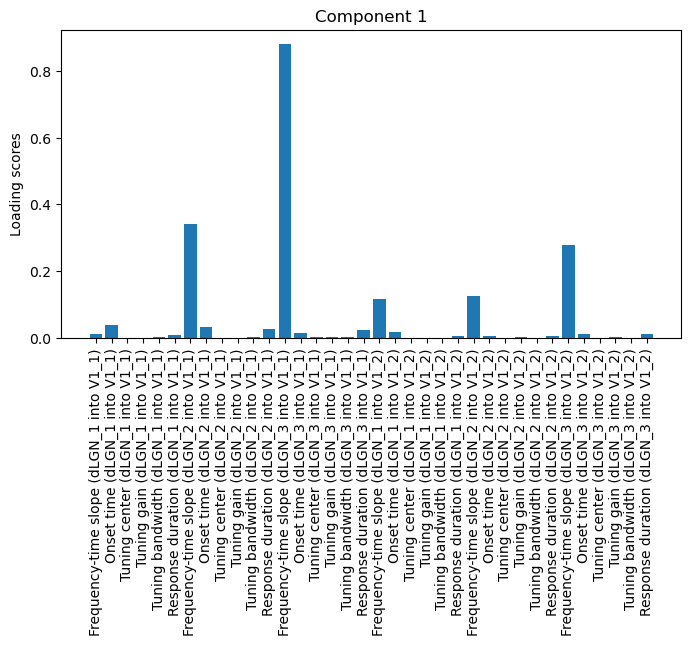

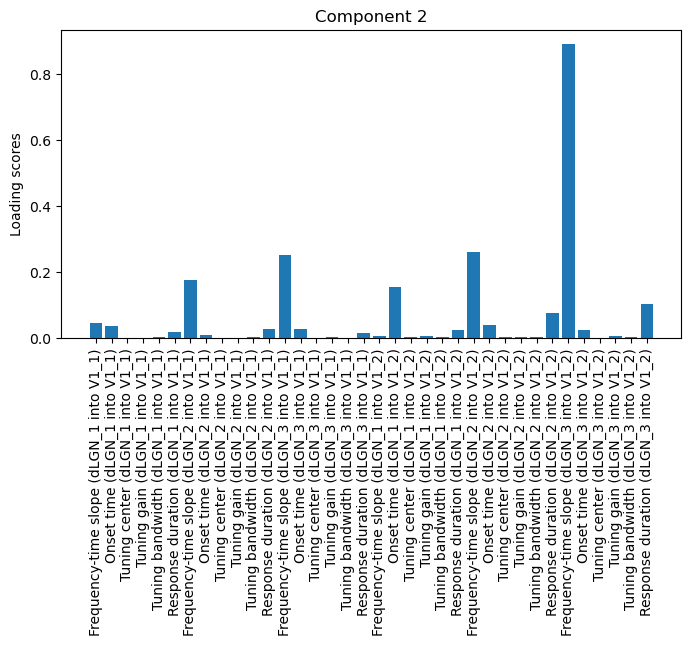

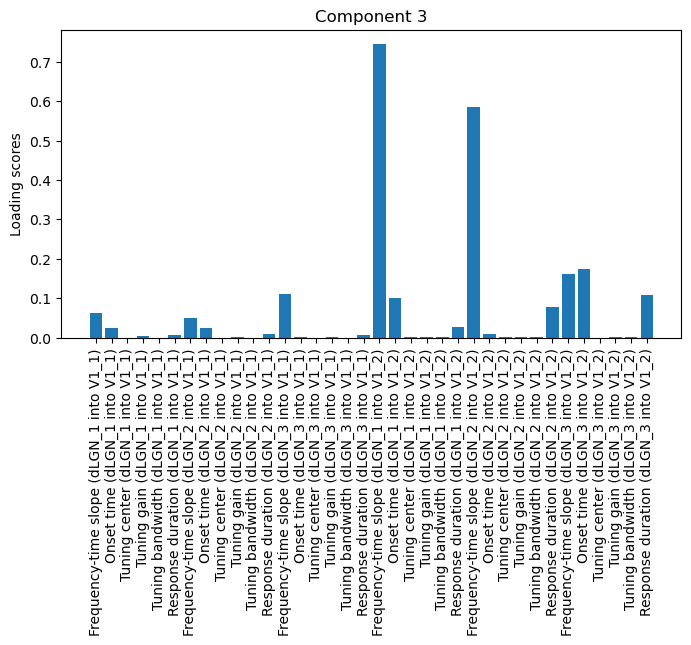

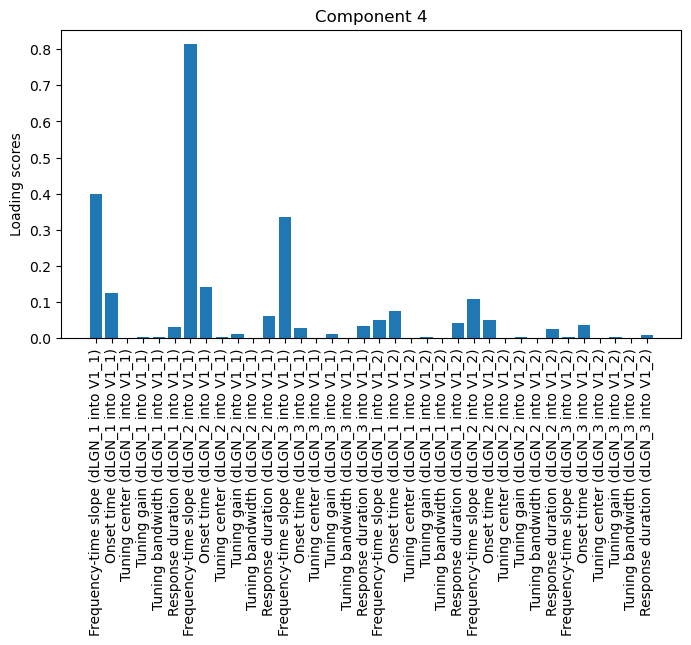

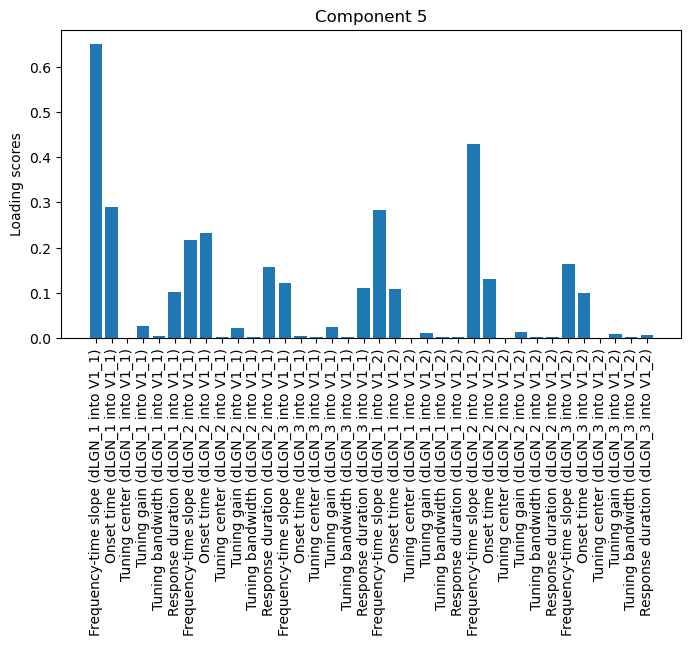

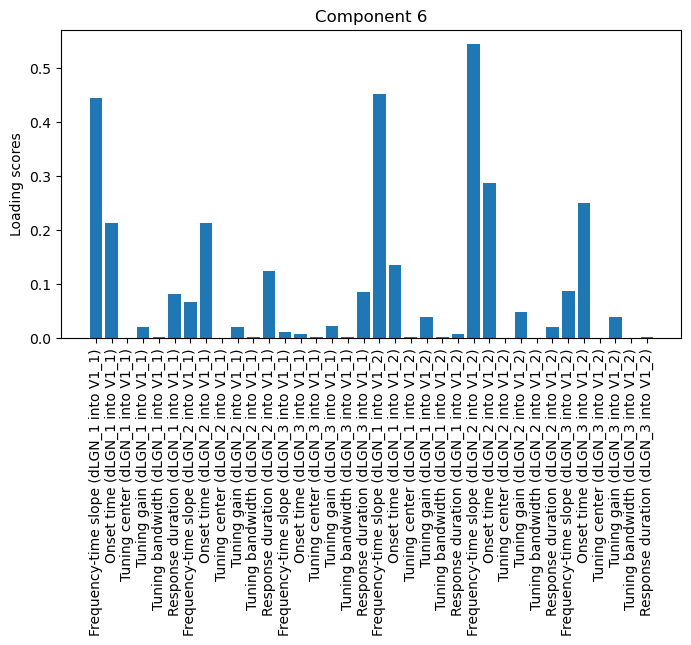

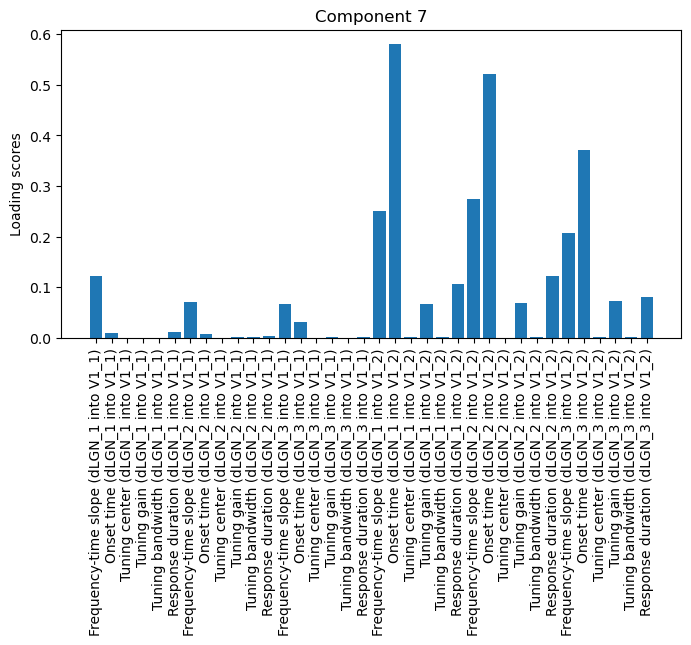

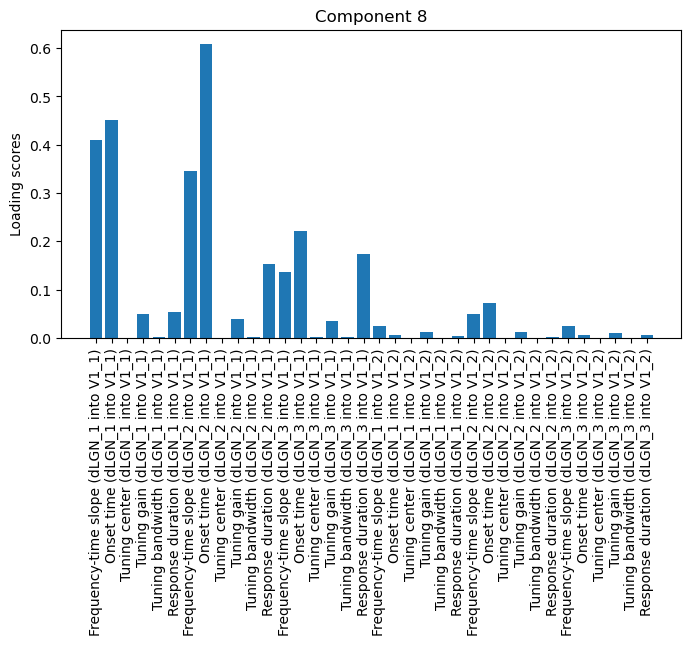

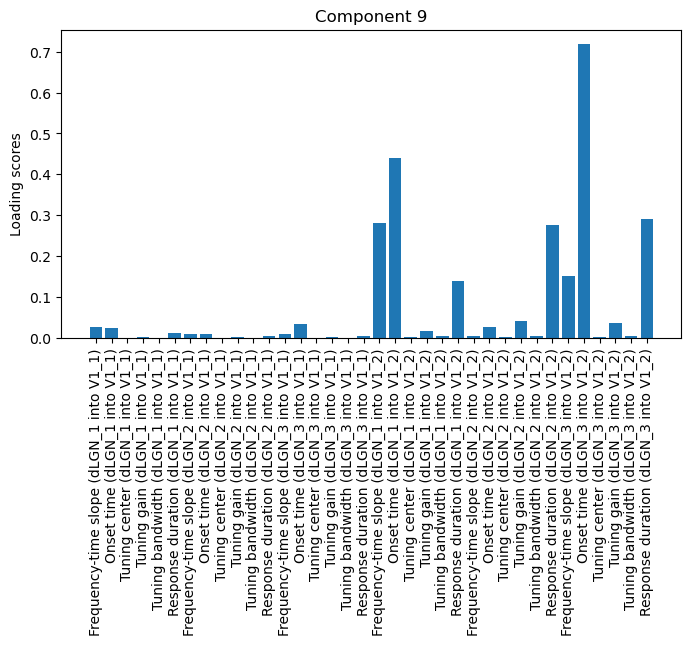

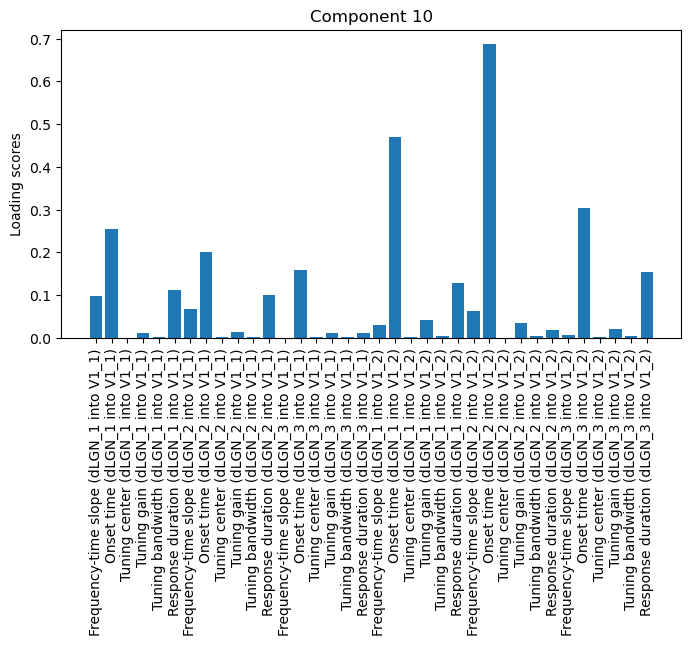

In [52]:
for i in range(10):
    fig, ax = plt.subplots(figsize = (8, 4))
    ax.bar(np.arange(36), np.abs(pca.components_[i]))
    ax.set_xticks(np.arange(36))
    ax.set_xticklabels(param_names[:36], rotation = 90)
    ax.set_ylabel("Loading scores")
    ax.set_title(f"Component {i+1}")